In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
#needed for Jupyter Notebook, if want plots to show inline
%matplotlib inline 
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [2]:
import glob
import re
plt.style.available
plt.style.use('seaborn-colorblind')

In [3]:
from sklearn.cluster import KMeans
from collections import Counter
from scipy.spatial.distance import pdist, squareform


## Loading data

In [4]:
def read2000sMatches(dirname):
    allFiles = glob.glob(dirname + "/atp_matches_2" + "*.csv")
    matches = pd.DataFrame()
    list_ = list()
    for filen in allFiles:
        df = pd.read_csv(filen,
                         index_col=None,
                         header=0,
                         parse_dates=[0])
                         #date_parser=lambda t:parse(t))
        list_.append(df)
    matches = pd.concat(list_)
    return matches

def read1900sMatches(dirname):
    allFiles = glob.glob(dirname + "/atp_matches_1" + "*.csv")
    matches = pd.DataFrame()
    list_ = list()
    for filen in allFiles:
        df = pd.read_csv(filen,
                         index_col=None,
                         header=0,
                         parse_dates=[0])
                         #date_parser=lambda t:parse(t))
        list_.append(df)
    matches = pd.concat(list_)
    return matches

In [5]:
matches2000s=read2000sMatches('tennis/')
matches1900s=read1900sMatches('tennis/')
matches_SackmannAll = pd.concat([matches1900s,matches2000s])
matches_SackmannAll.shape # (167879, 49)

(167879, 49)

## Take only data with detailed stats

In [6]:
df_stats = matches_SackmannAll[~pd.isnull(matches_SackmannAll['w_ace'])]
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81281 entries, 15 to 2823
Data columns (total 49 columns):
tourney_id            81281 non-null object
tourney_name          81281 non-null object
surface               81281 non-null object
draw_size             81281 non-null int64
tourney_level         81281 non-null object
tourney_date          81281 non-null int64
match_num             81281 non-null int64
winner_id             81281 non-null int64
winner_seed           36056 non-null float64
winner_entry          10452 non-null object
winner_name           81281 non-null object
winner_hand           81275 non-null object
winner_ht             78590 non-null float64
winner_ioc            81281 non-null object
winner_age            81268 non-null float64
winner_rank           79430 non-null float64
winner_rank_points    79430 non-null float64
loser_id              81281 non-null int64
loser_seed            19455 non-null float64
loser_entry           17509 non-null object
loser_name

In [7]:
df_lim = df_stats[['surface','winner_rank','winner_ht','winner_age','loser_rank','loser_ht','loser_age']] 

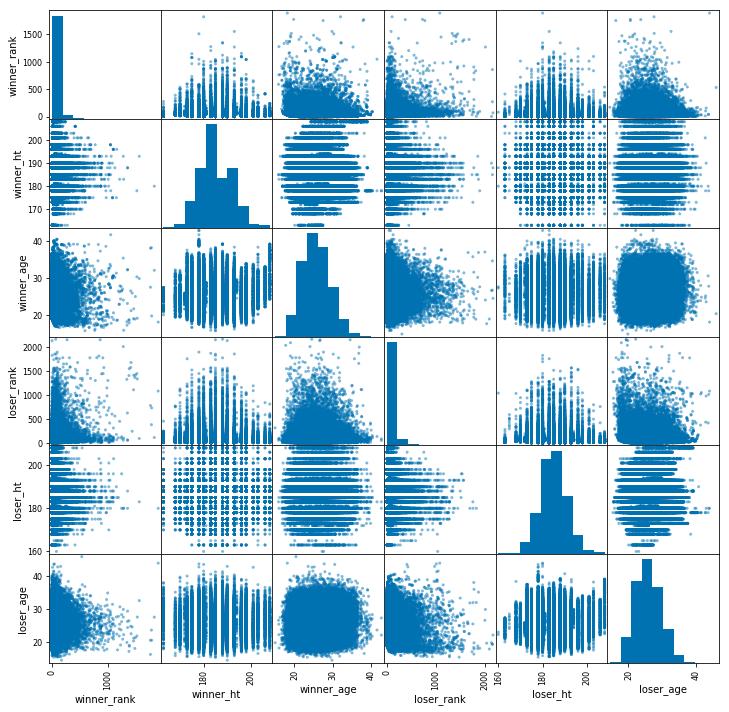

In [8]:
_ = pd.plotting.scatter_matrix(df_lim,figsize=(12,12))
#190 cm is 6'3"

In [9]:
df_win = df_stats[['tourney_id', 'match_num','tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date',  'score', 'best_of',
       'round', 'minutes','winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'winner_rank', 'winner_rank_points','w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
       'w_bpSaved', 'w_bpFaced']]
df_loss = df_stats[['tourney_id','match_num','tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date',  'score', 'best_of',
       'round', 'minutes','loser_id', 'loser_seed',
       'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'loser_rank', 'loser_rank_points','l_ace', 'l_df',
       'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
       'l_bpFaced']]

### Make 'win' and 'loss' columns compatible

#### Situation before

In [10]:
df_win_loss = pd.concat([df_win,df_loss],axis=1)
# each row has basic info repeated
# each row has two 'target'

#### Making compatible

In [11]:
df_win.columns = [s.replace("winner_", "") for s in df_win.columns]
df_win.columns = [s.replace("w_", "") for s in df_win.columns]
df_loss.columns = [s.replace("loser_", "") for s in df_win.columns]
df_loss.columns = [s.replace("l_", "") for s in df_win.columns]

df_win['target']=1
df_loss['target']=0
print(df_win.columns)
print()
print(df_loss.columns)

Index(['tourney_id', 'match_num', 'tourney_name', 'surface', 'drasize',
       'tourney_level', 'tourney_date', 'score', 'best_of', 'round', 'minutes',
       'id', 'seed', 'entry', 'name', 'hand', 'ht', 'ioc', 'age', 'rank',
       'rank_points', 'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon',
       'SvGms', 'bpSaved', 'bpFaced', 'target'],
      dtype='object')

Index(['tourney_id', 'match_num', 'tourney_name', 'surface', 'drasize',
       'tourney_level', 'tourney_date', 'score', 'best_of', 'round', 'minutes',
       'id', 'seed', 'entry', 'name', 'hand', 'ht', 'ioc', 'age', 'rank',
       'rank_points', 'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon',
       'SvGms', 'bpSaved', 'bpFaced', 'target'],
      dtype='object')


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [12]:
df_win_loss = pd.concat([df_win,df_loss])
df_win_loss.head()

,tourney_id,match_num,tourney_name,surface,drasize,tourney_level,tourney_date,score,best_of,round,minutes,id,seed,entry,name,hand,ht,ioc,age,rank,rank_points,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,target
15,1992-237,1,Guaruja,Hard,32,A,19921026,6-4 6-4,3,R32,97.0,101063,1.0,NaN,Jordi Arrese,R,175.0,ESP,28.158795,29.0,946.0,4.0,0.0,67.0,44.0,30.0,11.0,10.0,5.0,7.0,1
16,1992-237,2,Guaruja,Hard,32,A,19921026,6-2 6-4,3,R32,65.0,100652,NaN,WC,Cassio Motta,R,180.0,BRA,32.676249,201.0,171.0,7.0,4.0,52.0,35.0,29.0,9.0,9.0,1.0,1.0,1
17,1992-237,3,Guaruja,Hard,32,A,19921026,6-1 6-4,3,R32,82.0,101594,NaN,Q,Carsten Arriens,R,193.0,GER,23.542779,210.0,160.0,4.0,0.0,58.0,39.0,32.0,10.0,9.0,3.0,3.0,1
18,1992-237,4,Guaruja,Hard,32,A,19921026,7-6(4) 6-1,3,R32,95.0,101761,7.0,NaN,Jaime Oncins,R,196.0,BRA,22.362765,52.0,650.0,5.0,7.0,73.0,44.0,35.0,11.0,10.0,3.0,5.0,1
19,1992-237,5,Guaruja,Hard,32,A,19921026,6-3 3-6 6-4,3,R32,123.0,101174,NaN,WC,Fernando Roese,R,190.0,BRA,27.173169,187.0,185.0,4.0,4.0,79.0,47.0,33.0,11.0,14.0,4.0,10.0,1


In [13]:
df_win_loss.tail(2)
#seed, entry (str),have mostly missing values
#rank, and rank_points have ~4000 missign out of 162000
# 2 scores missing,~5000 missing minutes, ~35 missing 'hand', 
# ~7000 missing heights, ~100 missing age
df_win_loss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162562 entries, 15 to 2823
Data columns (total 31 columns):
tourney_id       162562 non-null object
match_num        162562 non-null int64
tourney_name     162562 non-null object
surface          162562 non-null object
drasize          162562 non-null int64
tourney_level    162562 non-null object
tourney_date     162562 non-null int64
score            162560 non-null object
best_of          162562 non-null int64
round            162562 non-null object
minutes          157280 non-null float64
id               162562 non-null int64
seed             55511 non-null float64
entry            27961 non-null object
name             162562 non-null object
hand             162528 non-null object
ht               155323 non-null float64
ioc              162562 non-null object
age              162488 non-null float64
rank             158636 non-null float64
rank_points      158636 non-null float64
ace              162562 non-null float64
df        

#### Fill missing values

In [14]:
#seed, entry (str),have 

# 2 scores missing,~5000 missing minutes, ~35 missing 'hand', 
# ~7000 missing heights, ~100 missing age





## fill method of entry for most players with 'standard'; mostly missing values
df_win_loss['entry'] = df_win_loss['entry'].fillna('standard')

## better way might be max(33,rank) ## 33 is the minumum non-seeded value
##high positive value because negative associates with better rank
df_win_loss['seed'] = df_win_loss['seed'].fillna(9999)
df_win_loss['seed'] = df_win_loss['seed'].astype(int)

#rank, and rank_points have ~4000 missign out of 162000
df_win_loss[['rank','rank_points']] = df_win_loss.groupby('name')[['rank','rank_points']]\
                                        .transform(lambda x: x.fillna(x.mean()))
#rank, and rank_points have some more missing values: set to maximum ranking and minimum rank points
df_win_loss['rank'] = df_win_loss['rank']\
                                        .transform(lambda x: x.fillna(x.max()))
df_win_loss['rank_points'] = df_win_loss['rank_points']\
                                        .transform(lambda x: x.fillna(x.min()))


#### check effectiveness of filling

In [15]:
#length 0, good
len(df_win_loss.loc[pd.isnull(df_win_loss['entry']),'entry'])
#length 0, good
len(df_win_loss.loc[pd.isnull(df_win_loss['seed']),'seed'])
# length 179
len(df_win_loss.loc[pd.isnull(df_win_loss['rank']),'rank'])
# length 179
len(df_win_loss.loc[pd.isnull(df_win_loss['rank_points']),'rank_points'])

# missing values for 'rank','rank_points' are either unusual 'entry' (Q,LL,WC) or are Davis cup matches
# .. 'tourney_id' contains '-DC-' and 'tourney_name' contains 'Davis Cup'
df_win_loss.loc[pd.isnull(df_win_loss['rank']),:].head(100)
# df_win_loss.loc[pd.isnull(df_win_loss['rank']),:].tail(100)

,tourney_id,match_num,tourney_name,surface,drasize,tourney_level,tourney_date,score,best_of,round,minutes,id,seed,entry,name,hand,ht,ioc,age,rank,rank_points,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,target
534,1992-426,13,Johannesburg,Hard,32,A,19920330,0-6 6-1 6-4,3,R32,NaN,101227,9999,Q,Daniel Marco,R,178.0,ESP,26.160164,NaN,NaN,6.0,12.0,89.0,38.0,30.0,20.0,11.0,10.0,13.0,1
1630,1992-468,2,Estoril,Clay,32,A,19920330,6-1 6-1,3,R32,56.0,101716,9999,Q,Javier Molina,R,178.0,ESP,22.045175,NaN,NaN,0.0,0.0,39.0,22.0,14.0,13.0,7.0,0.0,1.0,1
2459,1993-407,5,Rotterdam,Carpet,32,A,19930222,6-4 6-4,3,R32,80.0,108043,9999,LL,Ralph Kok,R,NaN,NED,NaN,NaN,NaN,9.0,4.0,64.0,28.0,25.0,19.0,10.0,3.0,3.0,1
915,1995-426,10,Johannesburg,Hard,32,A,19950403,3-6 6-3 7-6(5),3,R32,112.0,101980,9999,Q,Howard Joffe,R,NaN,RSA,23.441478,NaN,NaN,7.0,3.0,98.0,46.0,40.0,26.0,15.0,2.0,4.0,1
2516,2000-325,15,Palermo,Clay,32,A,20000925,6-4 6-2,3,R32,89.0,102738,9999,WC,Stefano Tarallo,R,185.0,ITA,24.550308,NaN,NaN,1.0,6.0,59.0,38.0,27.0,11.0,9.0,3.0,4.0,1
2700,2017-M-DC-2017-G2-AM-M-BAR-PAR-01,1,Davis Cup G2 R1: BAR vs PAR,None,4,D,20170203,7-6(5) 7-5 6-2,5,RR,150.0,137018,9999,standard,Ayed Zatar,R,NaN,PAR,20.840520,NaN,NaN,6.0,2.0,105.0,59.0,43.0,24.0,16.0,4.0,7.0,1
2703,2017-M-DC-2017-G2-AM-M-BAR-PAR-01,5,Davis Cup G2 R1: BAR vs PAR,None,4,D,20170203,6-3 6-2,3,RR,67.0,200621,9999,standard,Bruno Britez,NaN,NaN,PAR,18.691307,NaN,NaN,5.0,3.0,53.0,41.0,32.0,7.0,9.0,3.0,3.0,1
2758,2017-M-DC-2017-G2-EPA-M-LTU-MAD-01,2,Davis Cup G2 R1: LTU vs MAD,None,4,D,20170203,6-4 6-4 6-3,3,RR,97.0,105182,9999,standard,Antso Rakotondramanga,U,NaN,MAD,28.539357,NaN,NaN,11.0,1.0,78.0,51.0,40.0,17.0,15.0,0.0,0.0,1
2760,2017-M-DC-2017-G2-EPA-M-LTU-MAD-01,5,Davis Cup G2 R1: LTU vs MAD,None,4,D,20170203,6-3 4-6 6-2,3,RR,89.0,200272,9999,standard,Jean Jacques Rakotohasy,NaN,NaN,MAD,22.439425,NaN,NaN,8.0,6.0,80.0,50.0,36.0,21.0,14.0,2.0,3.0,1
2768,2017-M-DC-2017-G2-EPA-M-MON-SLO-01,5,Davis Cup G2 R1: MON vs SLO,None,4,D,20170203,1-6 6-4 6-2,3,RR,89.0,103531,9999,standard,Thomas Oger,U,NaN,MON,36.859685,NaN,NaN,7.0,3.0,71.0,41.0,28.0,13.0,13.0,3.0,8.0,1


In [16]:
df_win_loss['hand'].unique()#'R', 'L', 'U', nan
df_win_loss['hand'].value_counts()

R    138155
L     23661
U       712
Name: hand, dtype: int64

#### more filling of missing values

In [ ]:
### for this 1st epicycle: don't want score, 





# 2 scores missing,, , 
# 

## set 'hand' to U ('unknown') ~35 missing 'hand'
df_win_loss['hand'] = df_win_loss['hand'].fillna('U')

In [ ]:
# set missing height, age  to average for all people ~7000 missing heights, ~100 missing age
df_win_loss[['age','ht']] = df_win_loss[['age','ht']]\
                                        .transform(lambda x: x.fillna(x.mean()))

In [40]:
## set missing minutes to average age of all ~5000 missing minutes
df_win_loss['minutes'] = df_win_loss['minutes']\
                                        .transform(lambda x: x.fillna(x.mean()))

In [ ]:
(df_win_loss['age']).value_counts() #87 (most) occurrences of 23.7919
len(df_win_loss.loc[pd.isnull(df_win_loss['age']),'age']) # 0 good
(df_win_loss['ht']).value_counts() #25899 (most) occureences of 185 (cm)
len(df_win_loss.loc[pd.isnull(df_win_loss['ht']),'ht']) # 0 good

In [43]:
df_win_loss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162562 entries, 15 to 2823
Data columns (total 35 columns):
tourney_id       162562 non-null object
match_num        162562 non-null int64
tourney_name     162562 non-null object
drasize          162562 non-null int64
tourney_level    162562 non-null object
tourney_date     162562 non-null int64
score            162560 non-null object
best_of          162562 non-null int64
round            162562 non-null object
minutes          162562 non-null float64
id               162562 non-null int64
seed             162562 non-null int64
entry            162562 non-null object
name             162562 non-null object
hand             162562 non-null object
ht               162562 non-null float64
ioc              162562 non-null object
age              162562 non-null float64
rank             162562 non-null float64
rank_points      162562 non-null float64
ace              162562 non-null float64
df               162562 non-null float64
svpt     

In [27]:
df_win_loss['hand'].value_counts() #R    138155 L     23661 U       746

R    138155
L     23661
U       746
Name: hand, dtype: int64

In [18]:
df_win_loss['rank'].value_counts()
max(df_win_loss['rank'].unique()) #2159!
max(df_loss['rank']) # checks: rank 2159 does exist

2159.0

In [19]:
df_win_loss.columns
type(df_win_loss.info()) # none type
# df_win_loss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162562 entries, 15 to 2823
Data columns (total 31 columns):
tourney_id       162562 non-null object
match_num        162562 non-null int64
tourney_name     162562 non-null object
surface          162562 non-null object
drasize          162562 non-null int64
tourney_level    162562 non-null object
tourney_date     162562 non-null int64
score            162560 non-null object
best_of          162562 non-null int64
round            162562 non-null object
minutes          157280 non-null float64
id               162562 non-null int64
seed             162562 non-null int64
entry            162562 non-null object
name             162562 non-null object
hand             162562 non-null object
ht               155323 non-null float64
ioc              162562 non-null object
age              162488 non-null float64
rank             162383 non-null float64
rank_points      162383 non-null float64
ace              162562 non-null float64
df        

NoneType

Index(['tourney_id', 'match_num', 'tourney_name', 'surface', 'drasize',
       'tourney_level', 'tourney_date', 'score', 'best_of', 'round', 'minutes',
       'id', 'seed', 'entry', 'name', 'hand', 'ht', 'ioc', 'age', 'rank',
       'rank_points', 'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon',
       'SvGms', 'bpSaved', 'bpFaced', 'target'],
      dtype='object')

In [ ]:
df_win_loss['surface'].unique() #['Hard', 'Carpet', 'Clay', 'Grass', 'None']
df_win_loss['surface'].value_counts()
df_win_loss = pd.concat([df_win_loss,\
                         pd.get_dummies(df_win_loss['surface'])],axis=1)
df_win_loss = pd.concat([df_win_loss,\
                         pd.get_dummies(df_win_loss['hand'])],axis=1)

In [38]:
df_win_loss.columns

Index(['tourney_id', 'match_num', 'tourney_name', 'drasize', 'tourney_level',
       'tourney_date', 'score', 'best_of', 'round', 'minutes', 'id', 'seed',
       'entry', 'name', 'hand', 'ht', 'ioc', 'age', 'rank', 'rank_points',
       'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved',
       'bpFaced', 'target', 'Carpet', 'Clay', 'Grass', 'Hard', 'None'],
      dtype='object')

* Hard      80028 
* Clay      54282 
* Grass     16366 
* Carpet    11736 
* None        150 

Name: surface, dtype: int64

In [21]:
df_wl_surf = df_win_loss.drop('surface', axis=1,inplace=True)
        
# # df = pd.concat([df,pd.get_dummies(df['phone'])],axis = 1)

## unsupervised to identify most important *latent* features
_Table until time is there later_

In [22]:
matches_by_name = df_win_loss.groupby('name').aggregate(np.mean)
matches_by_name.tail()
matches_by_name.columns

Index(['match_num', 'drasize', 'tourney_date', 'best_of', 'minutes', 'id',
       'seed', 'ht', 'age', 'rank', 'rank_points', 'ace', 'df', 'svpt',
       '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced', 'target',
       'Carpet', 'Clay', 'Grass', 'Hard', 'None'],
      dtype='object')

Most relevant features, AK opinion
['rank' or  'rank_points' or 'target'or 'tourney_level'  == 'how much a winner/skill' ] ['surface'==style],',  [==], ', , 'round', ['minutes'=='how much a grinder"], 'id', 'seed',  'age'[too variable across my data], , ['ace'==power], 'df', 'svpt', '1stIn', '1stWon', '2ndWon', ', 'bpSaved', 'bpFaced', ],

In [23]:
df_cluster = matches_by_name[['target', 'Clay','Grass','Hard','bpFaced']]
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2156 entries, Aaron Krickstein to Zsombor Piros
Data columns (total 5 columns):
target     2156 non-null float64
Clay       2156 non-null float64
Grass      2156 non-null float64
Hard       2156 non-null float64
bpFaced    2156 non-null float64
dtypes: float64(5)
memory usage: 101.1+ KB


In [24]:
kmeans=KMeans(n_clusters=8)
kmeans.fit(df_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Problems

* *used all the data to get average rank: not terrible but leverages future data* : used for filling missing 'rank' and 'rank_points' (?)
* *missing seeds, put -9999, should put high positive value because negative associates with better rank*
* *mising ranks (after filling with plyaer average) filled with maximum rank*: is that ok?
* *mising age ht (height) minutes as average of all cols*: problem--players with higher ranks will be represented more

In [ ]:
* For scatter matrix plots, plot **differences** of eg. height, age 
* For comparing wins and losses, 

# Future Directions

* *Dastan: using S3 from which EC2 pulls -- would be a good skill set*
* *Joe: can open up a few EC2s*--model1, -model2, --grid search 
* *am **predicting** matches between players, so have to **train on** matches between plyaers*
* *Joe suggested to Sam: Do **lasso regression** and ***use** features with **large betas** for logistic or can do decision tree/RandomForest and get most important features

# Remedials

* For scatter matrix plots, plot **differences** of eg. height, age 
* For comparing wins and losses, 